In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from model_mlp import MLP
### Preparation ####

# set random seed
seed = 3
np.random.seed(seed)
torch.manual_seed(seed)

# set precision and device
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

### load dataset ###

def load_data(mode='train'):
    data = np.loadtxt('./data_{}.txt'.format(mode), dtype='str')
    inputs = data[:,:2]
    labels = data[:,2]

    def strs2mat(strings):
        num = strings.shape[0]
        mat = []
        for i in range(num):
            mat.append([*strings[i]])
        return mat

    inputs_ = np.transpose(np.array([strs2mat(inputs[:,0]), strs2mat(inputs[:,1])]), (1,2,0)).astype('float')
    labels_ = np.array(strs2mat(labels))[:,:,np.newaxis].astype('float')

    return inputs_, labels_

inputs_train, labels_train = load_data(mode='train')
inputs_test, labels_test = load_data(mode='test')

inputs_train = torch.tensor(inputs_train, dtype=torch.float64, requires_grad=True).to(device)
labels_train = torch.tensor(labels_train, dtype=torch.float64, requires_grad=True).to(device)
inputs_test = torch.tensor(inputs_test, dtype=torch.float64, requires_grad=True).to(device)
labels_test = torch.tensor(labels_test, dtype=torch.float64, requires_grad=True).to(device)

def l1(model):
    l1_reg = torch.tensor(0.).to(device)
    for param in model.parameters():
        l1_reg += torch.sum(torch.abs(param))
    return l1_reg

shp = [2, 3, 1] 
model = MLP(shp=shp).to(device)

### Training ###

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.0)
steps = 1001
log = 200
lamb = 0e-4


train_accuracies = []
test_accuracies = []

train_losses=[]
test_losses=[]
for step in range(steps):
    optimizer.zero_grad()
    pred_train = model(inputs_train)
    loss_train = torch.mean((pred_train-labels_train)**2)
    acc_train = torch.mean((abs(pred_train - labels_train) < 0.01).long().float())
    pred_test = model(inputs_test)
    loss_test = torch.mean((pred_test-labels_test)**2)
    acc_test = torch.mean((abs(pred_test - labels_test) < 0.01).long().float())

    reg = l1(model)
    loss = loss_train + lamb * reg

    loss.backward()
    optimizer.step()
    
    if step % log == 0:
        print("step = %d | train loss: %.2e | test loss %.2e | train acc: %.2e | test acc: %.2e | reg: %.2e "%(step, loss_train.cpu().detach().numpy(), loss_test.cpu().detach().numpy(), acc_train.cpu().detach().numpy(), acc_test.cpu().detach().numpy(), reg.cpu().detach().numpy()))
        train_accuracies.append(acc_train.cpu().detach().numpy())
        test_accuracies.append(acc_test.cpu().detach().numpy())

        train_losses.append(loss_train.cpu().detach().numpy())
        test_losses.append(loss_test.cpu().detach().numpy())
torch.save(model.state_dict(), './model_mlp')

cuda
step = 0 | train loss: 9.52e-01 | test loss 9.52e-01 | train acc: 0.00e+00 | test acc: 0.00e+00 | reg: 3.83e+00 
step = 200 | train loss: 5.61e-02 | test loss 5.62e-02 | train acc: 0.00e+00 | test acc: 0.00e+00 | reg: 5.23e+00 
step = 400 | train loss: 5.94e-04 | test loss 5.94e-04 | train acc: 2.45e-01 | test acc: 2.45e-01 | reg: 7.68e+00 
step = 600 | train loss: 2.59e-07 | test loss 2.60e-07 | train acc: 1.00e+00 | test acc: 1.00e+00 | reg: 7.90e+00 
step = 800 | train loss: 8.18e-12 | test loss 8.20e-12 | train acc: 1.00e+00 | test acc: 1.00e+00 | reg: 7.90e+00 
step = 1000 | train loss: 6.83e-18 | test loss 6.84e-18 | train acc: 1.00e+00 | test acc: 1.00e+00 | reg: 7.90e+00 


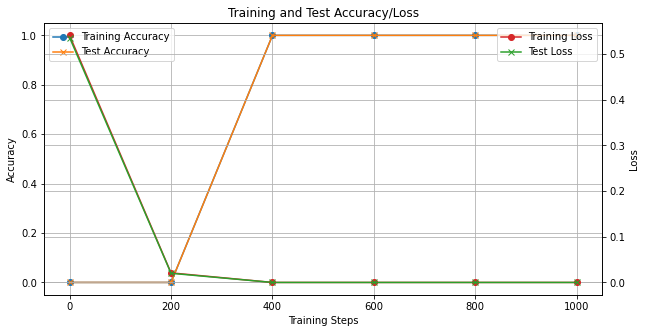

In [18]:
# Create a figure with twin y-axes
x_values = range(0, steps, log)
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the training and test accuracies on the first y-axis (left)
ax1.plot(x_values[:len(train_accuracies)], train_accuracies, label='Training Accuracy', marker='o', color='tab:blue')
ax1.plot(x_values[:len(test_accuracies)], test_accuracies, label='Test Accuracy', marker='x', color='tab:orange')
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Accuracy', color='black')
ax1.legend(loc='upper left')
ax1.grid()

# Create a second y-axis (right) for plotting losses
ax2 = ax1.twinx()
ax2.plot(x_values[:len(train_losses)], train_losses, label='Training Loss', marker='o', color='tab:red')
ax2.plot(x_values[:len(test_losses)], test_losses, label='Test Loss', marker='x', color='tab:green')
ax2.set_ylabel('Loss', color='black')
ax2.legend(loc='upper right')

# Title
plt.title('Training and Test Accuracy/Loss')
plt.grid()

plt.show()